In [3]:
!pip install datasets
!pip install sacremoses

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.0 MB/s eta 0:00:00


In [4]:
!export CUDA_LAUNCH_BLOCKING=1

In [5]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import spacy
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
#from tqdm import
from tqdm.auto import tqdm
from datasets import (
    load_dataset, Dataset, DatasetDict, load_from_disk
)
from torch.amp import autocast
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, random_split
from transformers import BertTokenizer, BertModel, MarianTokenizer
from collections import Counter, defaultdict
import numpy as np
import gc
gc.collect()

90

In [6]:
# Setting up the device for training (NVIDIA GPU (CUDA) or CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on", device)

Running on cuda


**Downloading and preparing data**

In [7]:
# Loading a dataset
dataset = load_dataset("Helsinki-NLP/europarl", 'en-fr')

print(f'Dataset info:', dataset)

# We take 10% of the dataset
num_rows = len(dataset['train'])
print(f"The original size of the dataset: {num_rows}")

num_rows_10_percent = int(0.1 * num_rows)

train_10_percent = dataset['train'].select(range(num_rows_10_percent))

dataset = DatasetDict({
    'train': train_10_percent
})

print(f"Sample size: {len(dataset)}")
print(f'Sample dataset info:', dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/76.3k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/193M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/186M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2051014 [00:00<?, ? examples/s]

Dataset info: DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 2051014
    })
})
The original size of the dataset: 2051014
Sample size: 1
Sample dataset info: DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 205101
    })
})


In [8]:
# Tokeniser for English and French.
tokenizer_en = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-fr", clean_up_tokenization_spaces=True)
tokenizer_fr = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-fr-en", clean_up_tokenization_spaces=True)

# Adding special tokens
unk_token = "<unk>"  # Token for unknown words
pad_token = "<pad>"  # Token for padding
sos_token = "<sos>"  # Token of the beginning of the sequence
eos_token = "<eos>"  # End of sequence token

special_tokens = [unk_token, pad_token, sos_token, eos_token]

# Adding special tokens to the tokeniser
tokenizer_en.add_special_tokens({'additional_special_tokens': special_tokens})
tokenizer_fr.add_special_tokens({'additional_special_tokens': special_tokens})

# Updating tokeniser dictionaries
#tokenizer_en.add_tokens(special_tokens)
#tokenizer_fr.add_tokens(special_tokens)

# Minimum frequency of tokens appearance
min_freq = 5

# Function for creating a frequency dictionary using token strings, not indices
def build_vocab(dataset, tokenizer_en, tokenizer_fr, min_freq):
    token_freq_en = {}
    token_freq_fr = {}

    # Go through the dataset and calculate the frequencies for both languages
    for item in dataset['translation']:
        # Tokenise an English sentence and get tokens in the form of strings
        tokens_en = tokenizer_en.tokenize(item['en'])
        for token in tokens_en:
            if token in token_freq_en:
                token_freq_en[token] += 1
            else:
                token_freq_en[token] = 1

        # Tokenise the French sentence and get the tokens as strings
        tokens_fr = tokenizer_fr.tokenize(item['fr'])
        for token in tokens_fr:
            if token in token_freq_fr:
                token_freq_fr[token] += 1
            else:
                token_freq_fr[token] = 1

    # We create new dictionaries based on the minimum frequency for English and French
    filtered_vocab_en = {token: freq for token, freq in token_freq_en.items() if freq >= min_freq}
    filtered_vocab_fr = {token: freq for token, freq in token_freq_fr.items() if freq >= min_freq}

    return filtered_vocab_en, filtered_vocab_fr

# Create dictionaries based on the minimum frequency
vocab_en, vocab_fr = build_vocab(dataset['train'], tokenizer_en, tokenizer_fr, min_freq)

print(f"English vocab size: {len(vocab_en)}")
print(f"French vocab size: {len(vocab_fr)}")

# Updating the tokenizers by adding new tokens (if necessary)
# If you've built vocabularies separately, and they include new words that were not part of the original tokenizer, you can use add_tokens() to add them
new_tokens_en = list(vocab_en.keys())
new_tokens_fr = list(vocab_fr.keys())

print(f'Size of new_tokens_en', len(new_tokens_en))
print(f'Size of new_tokens_fr', len(new_tokens_fr))

# Adding new tokens to the tokenizers if there are any
tokenizer_en.add_tokens(new_tokens_en)
tokenizer_fr.add_tokens(new_tokens_fr)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

English vocab size: 17068
French vocab size: 19880
Size of new_tokens_en 17068
Size of new_tokens_fr 19880


1

In [9]:
def tokenize_data(batch, tokenizer_en, tokenizer_fr, max_length=128):
    # Get sentences in English and French from batch
    source_sentences = [item['en'] for item in batch['translation']]
    target_sentences = [item['fr'] for item in batch['translation']]

    # Tokenise each sentence batch, add an attention mask, apply padding and truncation to max_length
    inputs = tokenizer_en(
        source_sentences,
        padding='max_length',  # Add padding to max_length
        truncation=True,  # Truncate sequences that are longer than max_length
        max_length=max_length,
        return_tensors='pt'  # Повертаємо тензори PyTorch
    )

    targets = tokenizer_fr(
        target_sentences,
        padding='max_length',  # Add padding to max_length
        truncation=True,  # Truncate sequences
        max_length=max_length,
        return_tensors='pt'   # Returning PyTorch tensors
    )

    return {
        'input_ids': inputs['input_ids'],  # Tokenised English data
        'attention_mask': inputs['attention_mask'],  # Attention mask for English data
        'labels': targets['input_ids']  # Tokenised French data for the model
    }

In [10]:
# Specify the path for cached data
cache_dir = './cached_train_data'

# Try to load cached data
try:
    print("Loading cached data...")
    train_data = load_from_disk(cache_dir)
    print(f"Data loaded from {cache_dir}")

except FileNotFoundError:
    print("Cached data not found. Performing tokenisation...")

    # If cached data is not found, perform tokenisation
    max_length = 128
    train_data = dataset['train'].map(
        lambda x: tokenize_data(x, tokenizer_en, tokenizer_fr, max_length=max_length),
        batched=True
    )

    # Save the tokenised data to disc
    train_data.save_to_disk(cache_dir)
    print(f"The data is saved in {cache_dir}")

Loading cached data...
Cached data not found. Performing tokenisation...


Map:   0%|          | 0/205101 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/205101 [00:00<?, ? examples/s]

The data is saved in ./cached_train_data


In [11]:
# Using the built-in train_test_split method to split into training and validation sets
train_val_split = train_data.train_test_split(test_size=0.2, seed=42)

# Separate training and validation kits
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

Training dataset size: 164080
Validation dataset size: 41021


**Function for processing batches of different lengths**

In [12]:
def collate_fn(batch):
    input_ids = [torch.tensor(entry['input_ids']) for entry in batch]
    attention_mask = [torch.tensor(entry['attention_mask']) for entry in batch]
    labels = [torch.tensor(entry['labels']) for entry in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer_en.pad_token_id)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=tokenizer_fr.pad_token_id)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_mask_padded,
        'labels': labels_padded
    }

**Creating a DataLoader**

In [13]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn)

**Creating a Seq2Seq model: Encoder**

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)  # Bidirectional GRU, so multiply by 2
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [src_len, batch_size]
        embedded = self.dropout(self.embedding(src))  # embedded: [src_len, batch_size, emb_dim]
        outputs, hidden = self.rnn(embedded)  # outputs: [src_len, batch_size, hid_dim * 2], hidden: [n_layers * 2, batch_size, hid_dim]
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))  # Combining bidirectional states
        return outputs, hidden  # Return encoder outputs and hidden states for the decoder


**Creating a Seq2Seq model: Decoder with attention mechanism**

In [15]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim)
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden (batch_size, decoder_hidden_dim)
        # encoder_outputs (src_length, batch_size, encoder_hidden dim * 2)

        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]

        # Repeat the hidden state of the decoder for each element of the input sequence
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)  # (batch_size, src_length, decoder_hidden_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch_size, src_length, encoder_hidden_dim * 2)

        # Combine hidden decoder states and encoder outputs
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch_size, src_length, decoder_hidden_dim)

        attention = self.v_fc(energy).squeeze(2)  # (batch_size, src_length)

        return torch.softmax(attention, dim=1)

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear((encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        # input: (batch_size)
        # hidden: (batch_size, decoder_hidden_dim)
        # encoder_outputs: (src_length, batch_size, encoder_hidden_dim * 2)

        input = input.unsqueeze(0)  # Convert to [1, batch_size]
        embedded = self.embedding(input)  # [1, batch_size, embedding_dim]

        # We get the weight of attention
        a = self.attention(hidden, encoder_outputs)  # [batch_size, src_length]
        a = a.unsqueeze(1)  # [batch_size, 1, src_length]

        # Convert encoder_outputs for batch-wise multiplication
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # [batch_size, src_length, encoder_hidden_dim * 2]

        # Calculate weights using batch matrix-matrix product
        weighted = torch.bmm(a, encoder_outputs)  # [batch_size, 1, encoder_hidden_dim * 2]
        weighted = weighted.permute(1, 0, 2)  # [1, batch_size, encoder_hidden_dim * 2]

        # Combining inputs for RNNs
        rnn_input = torch.cat((embedded, weighted), dim=2)  # [1, batch_size, (encoder_hidden_dim * 2) + embedding_dim]

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))  # output = [1, batch_size, decoder_hidden_dim]

        # Extract the first (and only) element for convenience
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        # Latest forecast: combine all values
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))  # [batch_size, output_dim]

        return prediction, hidden.squeeze(0)

**Creating a Seq2Seq model: Combining into a Seq2Seq model**

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, trg, teacher_forcing_ratio=0.3):
        encoder_outputs, hidden = self.encoder(src)
        trg_len = trg.shape[0]
        outputs = torch.zeros(trg_len, trg.shape[1], self.decoder.output_dim).to(trg.device)
        input = trg[0, :]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = np.random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1
        return outputs

**Creating a model instance**

In [18]:
!export CUDA_LAUNCH_BLOCKING=1
# Set the necessary parameters for the model
INPUT_DIM = len(tokenizer_en.get_vocab())  # Dictionary size for the input language
OUTPUT_DIM = len(tokenizer_fr.get_vocab())  # Vocabulary size for the target language

#INPUT_DIM = len(vocab_en)
#OUTPUT_DIM = len(vocab_fr)

print(f'INPUT_DIM size is', INPUT_DIM)
print(f'OUTPUT_DIM size is', OUTPUT_DIM)
ENC_EMB_DIM = 128  # Dimensionality of vectors for the encoder
DEC_EMB_DIM = 128  # Dimensionality of vectors for the decoder
ENC_HID_DIM = 256  # Dimensionality of hidden states for the encoder
DEC_HID_DIM = 256  # Dimensionality of hidden states for the decoder
N_LAYERS = 1  # Number of layers in the RNN
ENC_DROPOUT = 0.5  # Dropout for the encoder
DEC_DROPOUT = 0.5  # Dropout for the decoder

# Initialise the attention mechanism
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)

# Initialise the encoder and decoder with the transfer of the corresponding parameters
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)  # Pass only the required parameters
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, attn)  # Decoder with attention

# Create a Seq2Seq model
seq2seq_model = Seq2Seq(enc, dec).to(device)

# Update embedding for EN (encoder)
seq2seq_model.encoder.embedding = nn.Embedding(len(tokenizer_en), ENC_EMB_DIM)

# Update the embedding for FR (decoder)
seq2seq_model.decoder.embedding = nn.Embedding(len(tokenizer_fr), DEC_EMB_DIM)

#seq2seq_model.encoder.embedding = nn.Embedding(len(tokenizer_en.get_vocab()), seq2seq_model.encoder.embedding.embedding_dim)
#seq2seq_model.decoder.embedding = nn.Embedding(len(tokenizer_fr.get_vocab()), seq2seq_model.decoder.embedding.embedding_dim)

print(f"Updated embedding size for EN: {seq2seq_model.encoder.embedding.num_embeddings}")
print(f"Updated embedding size for FR: {seq2seq_model.decoder.embedding.num_embeddings}")
print(f"Updated dictionary size EN: {len(tokenizer_en.get_vocab())}")
print(f"Updated dictionary size FR: {len(tokenizer_fr.get_vocab())}")

print(seq2seq_model)

INPUT_DIM size is 59517
OUTPUT_DIM size is 59517


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Updated embedding size for EN: 59517
Updated embedding size for FR: 59517
Updated dictionary size EN: 59517
Updated dictionary size FR: 59517
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(59517, 128)
    (rnn): GRU(128, 256, dropout=0.5, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=768, out_features=256, bias=True)
      (v_fc): Linear(in_features=256, out_features=1, bias=False)
    )
    (embedding): Embedding(59517, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=59517, bias=True)
  )
)


**Defining the loss function and optimiser**

In [19]:
optimizer = optim.Adam(seq2seq_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer_fr.pad_token_id)
#criterion = nn.CrossEntropyLoss()

**Model training**

In [20]:
scaler = torch.amp.GradScaler()

def train(model, iterator, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0
    loop = tqdm(iterator, leave=True, desc="Training")

    for i, batch in enumerate(loop):
        src = batch['input_ids'].to(device)
        trg = batch['labels'].to(device)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda'):  # Use the new autocast syntax
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[1:].reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)
            loss = criterion(output, trg)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return epoch_loss / len(iterator)

**A function for model evaluation**

In [21]:
def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0

    # Add a progress bar
    loop = tqdm(iterator, leave=True, desc="Validating")

    with torch.no_grad():  # Grading without gradients
        for i, batch in enumerate(loop):
            # Transfer the input data to the correct device
            src = batch['input_ids'].to(device)
            trg = batch['labels'].to(device)

            # Use autocast for mixed accuracy
            with torch.amp.autocast(device_type='cuda'):
                output = model(src, trg, 0)  # We do not use teacher forcing for assessment

                output_dim = output.shape[-1]
                output = output[1:].reshape(-1, output_dim)
                trg = trg[1:].reshape(-1)

                # Calculating losses
                loss = criterion(output, trg)

            # Add losses to calculate the average value
            epoch_loss += loss.item()

            # Updating the progress bar
            loop.set_postfix(loss=loss.item())

    # Return the average loss for all iterations
    return epoch_loss / len(iterator)

**Visualisation of the loss function**

In [22]:
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Changing the loss function')
    plt.xlabel('Epoch')
    plt.ylabel('Losses')
    plt.legend()
    plt.show()

**Learning cycle for multiple eras**

In [23]:
seq2seq_model = seq2seq_model.to(device)
N_EPOCHS = 10
CLIP = 5

pad_token_id = tokenizer_en.pad_token_id

train_losses = []
val_losses = []
best_val_loss = float('inf')  # Initialise the best loss as infinity
patience = 3  # Number of epochs without improvement before stopping
counter = 0

for epoch in range(N_EPOCHS):
    print(f'Epoch {epoch+1}/{N_EPOCHS}')

    train_loss = train(seq2seq_model, train_loader, optimizer, criterion, CLIP, device)
    val_loss = evaluate(seq2seq_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Training loss: {train_loss:.3f}, Validation loss: {val_loss:.3f}')

    # If the current validation loss is better than the previous best, save the model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(seq2seq_model.state_dict(), 'best_seq2seq_model.pt')
        print(f'Best model saved with validation loss: {val_loss:.3f}')
        counter = 0  # Resetting the counter
    else:
        counter += 1

    if counter >= patience:
        print("Early stopping")
        break

Epoch 1/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 1, Training loss: 6.314, Validation loss: 6.146
Best model saved with validation loss: 6.146
Epoch 2/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 2, Training loss: 6.144, Validation loss: 6.133
Best model saved with validation loss: 6.133
Epoch 3/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 3, Training loss: 6.134, Validation loss: 6.128
Best model saved with validation loss: 6.128
Epoch 4/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 4, Training loss: 6.129, Validation loss: 6.125
Best model saved with validation loss: 6.125
Epoch 5/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 5, Training loss: 6.125, Validation loss: 6.123
Best model saved with validation loss: 6.123
Epoch 6/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 6, Training loss: 6.122, Validation loss: 6.119
Best model saved with validation loss: 6.119
Epoch 7/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 7, Training loss: 6.119, Validation loss: 6.118
Best model saved with validation loss: 6.118
Epoch 8/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 8, Training loss: 6.117, Validation loss: 6.116
Best model saved with validation loss: 6.116
Epoch 9/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 9, Training loss: 6.114, Validation loss: 6.114
Best model saved with validation loss: 6.114
Epoch 10/10


Training:   0%|          | 0/1282 [00:00<?, ?it/s]

Validating:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch 10, Training loss: 6.113, Validation loss: 6.113
Best model saved with validation loss: 6.113


**Building a graph of losses after the end of the training**

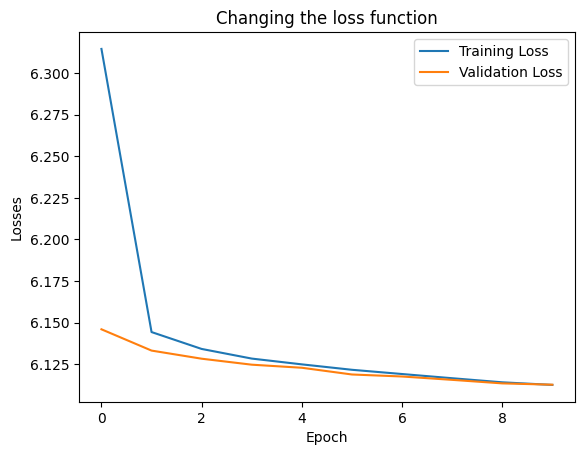

In [24]:
plot_loss(train_losses, val_losses)

In [27]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(5,5))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

**A function for translating a single sentence**

In [28]:
print(tokenizer_fr.special_tokens_map)

{'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<unk>', '<pad>', '<sos>', '<eos>']}


In [30]:
translated_tokens = [tokenizer_fr.convert_tokens_to_ids('<sos>')]

In [56]:
def translate_sentence(sentence, model, tokenizer_en, tokenizer_fr, device, max_len=128):
    # Switch the model to evaluation mode
    model.eval()

    # Tokenise the input sentence (in English)
    tokens = tokenizer_en(sentence, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
    input_ids = tokens['input_ids'].to(device)

    # Call the encoder to get the hidden state and outputs
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(input_ids)

    # Initialise the list for translated tokens, starting with the <sos> of the token
    translated_tokens = [tokenizer_fr.convert_tokens_to_ids('<sos>')]

    # Starting token for the decoder (beginning of the sentence)
    input_token = torch.tensor([translated_tokens[-1]]).unsqueeze(0).to(device)

    # Cyclically generate new words for the original sentence
    for _ in range(max_len):
        # Call the decoder to get the next word
        with torch.no_grad():
            output, hidden = model.decoder(input_token, hidden, encoder_outputs)

        # Get the index of the most likely token
        top_token = output.argmax(1).item()

        # Add a token to the translated sentence
        translated_tokens.append(top_token)

        # If the <eos> token is received, stop the translation
        if top_token == tokenizer_fr.eos_token_id:
            break

        # Update the input token for the decoder for the next iteration
        input_token = torch.tensor([top_token]).unsqueeze(0).to(device)

    # Convert the token list back to a sentence in French
    translated_sentence = tokenizer_fr.decode(translated_tokens, skip_special_tokens=True)

    return translated_sentence

**Example of use for translation**

In [58]:
# Define the sentence to be translated
sentence = "How are you?"

# Translate the sentence
translated_sentence = translate_sentence(sentence, seq2seq_model, tokenizer_en, tokenizer_fr, device)

print(f'Original (EN): {sentence}')
print(f'Translation (FR): {translated_sentence}')

RuntimeError: Tensors must have same number of dimensions: got 4 and 3

In [ ]:
#plot_attention()